In [8]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline
from tqdm.notebook import tqdm
import functools as ft
import optax
import treex as tx
from sdf_jax.discretize import discretize2d
from sdf_jax.util import plot2d

# Implicit Geometric Regularization

"Implicit Geometric Regularization for Learning Shapes"
Gropp et al. ICML 2020
https://arxiv.org/abs/2002.10099


![](igr_loss.png)

In [10]:
def sample_normal_per_point(key, xs, local_sigma=0.01):
    key, key_local, key_global = jrandom.split(key, 3)
    sample_local = xs + jrandom.normal(key_local, xs.shape) * local_sigma
    sample_global = jrandom.uniform(key_global, xs.shape)
    return jnp.vstack([sample_local, sample_global])

def surface_loss_fn(model, x):
    return jnp.abs(x)

def eikonal_loss_fn(model, x):
    return (jnp.linalg.norm(jax.grad(model)(x)) - 1.0)**2

@ft.partial(jax.value_and_grad, has_aux=True)
def loss_fn(params, model, xs, lam, key):
    model = model.merge(params)
    surface_loss = jnp.mean(jax.vmap(ft.partial(surface_loss_fn, model))(xs))
    xs_eik = sample_normal_per_point(key, xs)
    eikonal_loss = jnp.mean(jax.vmap(ft.partial(eikonal_loss_fn, model))(xs_eik))
    loss = surface_loss + lam * eikonal_loss
    return loss, model

@jax.jit
def train_step(model, xs, lam, optimizer, key):
    params = model.filter(tx.Parameter)
    (loss, model), grads = loss_fn(params, model, xs, lam, key)
    new_params = optimizer.update(grads, params)
    model = model.merge(new_params)
    return loss, model, optimizer

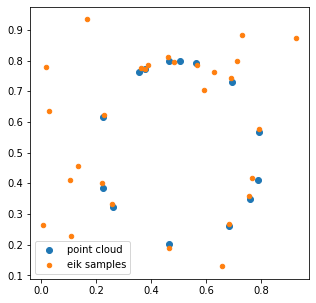

In [11]:
def sample_circle(key, nsamples=14, radius=0.3, center=jnp.array([0.5, 0.5])):
    key, theta_key = jrandom.split(key, 2)
    theta = 2 * jnp.pi * jrandom.uniform(theta_key, (nsamples,))
    xs = center + radius * jnp.vstack([jnp.cos(theta), jnp.sin(theta)]).T
    return xs

key = jrandom.PRNGKey(0)
xs = sample_circle(key)
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.scatter(*xs.T, label="point cloud")
ax.scatter(*sample_normal_per_point(key, xs).T, s=20, label="eik samples")
ax.legend()

(14, 2)


  0%|          | 0/10 [00:00<?, ?it/s]

[0] loss: 1.6141
[1] loss: nan
[2] loss: nan
[3] loss: nan
[4] loss: nan
[5] loss: nan
[6] loss: nan
[7] loss: nan
[8] loss: nan
[9] loss: nan
[9] loss: nan


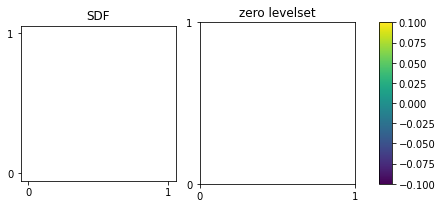

In [33]:
from typing import Callable, List

def softplus(x, beta=100):
    return jnp.logaddexp(beta*x, 0) / beta

class NeuralSDF(tx.Module):
    hidden_layers: List[tx.Linear]
    final_layer: tx.Linear
    def __init__(
        self, 
        input_dim: int, 
        depth: int, 
        hidden: int, 
        act: Callable=softplus,
        radius_init=1.0,
    ):
        self.input_dim = input_dim
        self.depth = depth
        self.hidden = hidden
        self.act = act
        self.radius_init = radius_init

        hidden_layers = []
        for i in range(self.depth):

            # prepare skip connection one layer earlier
            if i == 2:
                h = self.hidden - self.input_dim 
            else: 
                h = self.hidden

             # geometric initialization
            if i == self.depth:
                def kernel_init(key, shape, dtype):
                    mean = np.sqrt(np.pi) / np.sqrt(h)
                    stddev = 0.00001
                    return mean + stddev * jrandom.normal(key, shape, dtype)
                layer = tx.Linear(
                    h, 
                    kernel_init=kernel_init,
                    bias_init=jax.nn.initializers.constant(-self.radius_init),
                )
            else:
                layer = tx.Linear(
                    h,
                    kernel_init=jax.nn.initializers.normal(np.sqrt(2) / np.sqrt(h)),
                    bias_init=jax.nn.initializers.constant(0.0),
                )
            hidden_layers += [layer]
        self.hidden_layers = hidden_layers
        self.final_layer = tx.Linear(1)

    def __call__(self, x):
        assert x.ndim == 1

        # x is assumed in [0,1]^2
        # we now rescale to [-1,1]^2 for geometric init to work
        x = 2*x - 1.0

        y = x
        for (i, layer) in enumerate(self.hidden_layers):
            # skip connection to the fourth layer
            if i + 1 == 4:
                y = jnp.concatenate([y, x])
            y = layer(y)
            y = self.act(y)
        y = self.final_layer(y)
        return y[0]

def print_callback(step, loss, model, optimizer):
    print(f"[{step}] loss: {loss:.4f}")

def fit(
    xs,
    # module
    depth=7,
    hidden=64,
    act=softplus,
    lam=1.0,
    # optimizer
    key=jrandom.PRNGKey(1234),
    lr=5e-3,
    steps=100,
    # utils
    cb=print_callback,
    cb_every=10,
):
    key, model_key = jrandom.split(key, 2)
    model = NeuralSDF(input_dim=2, depth=7, hidden=hidden, act=act).init(model_key, xs[0])
    optimizer = tx.Optimizer(optax.adam(lr))
    optimizer = optimizer.init(model.filter(tx.Parameter))
    for step in tqdm(range(steps)):
        key, step_key = jrandom.split(key, 2)
        loss, model, optimizer = train_step(model, xs, lam, optimizer, step_key)
        if step % cb_every == 0:
            cb(step, loss, model, optimizer)
    cb(step, loss, model, optimizer)
    return loss, model

key = jax.random.PRNGKey(0)
xs = sample_circle(key)
print(xs.shape)
loss, model = fit(xs, steps=10, cb_every=1, act=jax.nn.relu)
plot2d(model)

/home/niku/Documents/cloud/tu/cgproject/neuralsdf_jax/sdf_jax/util.py:17: UserWarning: No contour levels were found within the data range.
  ax1.contour(ys, levels=[0.])


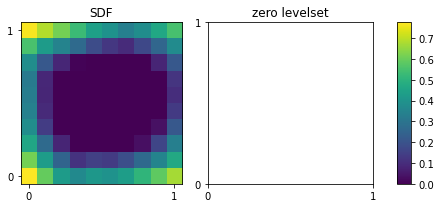

In [36]:
init_model = NeuralSDF(input_dim=2, depth=7, hidden=64).init(jrandom.PRNGKey(1234), inputs=xs[0])
plot2d(init_model)

  0%|          | 0/100 [00:00<?, ?it/s]

[0] loss: 0.5326
[10] loss: 0.5326
[20] loss: 0.5326
[30] loss: 0.5326
[40] loss: 0.5326
[50] loss: 0.5326
[60] loss: 0.5326
[70] loss: 0.5326
[80] loss: 0.5326
[90] loss: 0.5326
[99] loss: 0.5326


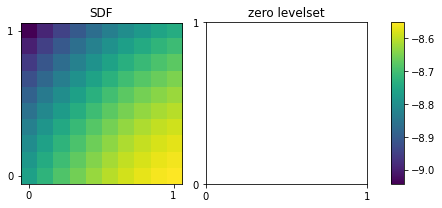

In [37]:
loss, model = fit(xs, act=jax.nn.softplus, lam=0.0)
plot2d(model)

TODO: geometric init

TODO: sampling of eikonal points as in paper

In [56]:
jax.nn.softplus

<CompiledFunction of <function softplus at 0x7fe422920160>>